In [4]:
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, AveragePooling2D, Dropout
from keras.layers import UpSampling2D
from keras.models import Model
from keras.models import load_model
from keras.utils import to_categorical
from keras.datasets import cifar10

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pickle, os, zipfile, glob
from tqdm import tqdm
from keras import backend as K

In [5]:
def basic_conv_block(input, chs, rep):
    x = input
    for i in range(rep):
        x = Conv2D(chs, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

def create_cnn2():
    from keras.applications import MobileNet
    net = MobileNet(input_shape=(128,128,3), weights=None, include_top=False)
    # upsampling(32->128)
    input = Input((32,32,3))
    x = UpSampling2D(4)(input)
    x = net(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(10, activation="softmax")(x)

    model = Model(input, x)
    model.summary()
    return model

In [7]:
model = create_cnn2()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total params: 3,239,114
Trainable params: 3,217,226
Non-trainable params: 21,888
_________________________________________________________________


In [12]:
import glob
vfn = glob.glob("result_supervised/*.h5")
print(vfn)
idx=1
print(vfn[idx])
fnmodel = vfn[idx]

['result_supervised/model_MobileNet_5000.h5', 'result_supervised/model_MobileNet_10000.h5', 'result_supervised/model_MobileNet_500.h5', 'result_supervised/model_MobileNet_50000.h5']
result_supervised/model_MobileNet_10000.h5


In [13]:
model1 = load_model(fnmodel)
print('Loaded model..... {}'.format(fnmodel))

Loaded model..... result_supervised/model_MobileNet_10000.h5


In [14]:
fn1 = fnmodel.split('/')[1]
fn1 = fn1.split('.')[0]
print(fn1)

model_MobileNet_10000


In [15]:
def tsne_plot(model):
    print('tsne-plot...')
    # tsne-plot
    emb_model = Model(model.input, model.layers[-2].output)
    emb_model.summary()
    # print(model.layers[-2].output)
    # Tensor("global_average_pooling2d_1/Mean:0", shape=(?, 1024), dtype=float32)
    
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    K.image_data_format()
    y_test_true = np.ravel(y_test)
    embedding = emb_model.predict(X_test)
    proj = TSNE(n_components=2).fit_transform(embedding)
    cmp = plt.get_cmap("tab10")
    plt.figure()

    for i in tqdm(range(10)):
        select_flag = y_test_true == i
        plt_latent = proj[select_flag, :]
        plt.scatter(plt_latent[:, 0], plt_latent[:, 1], color=cmp(i), marker=".")
    fnfig = "result_supervised/embedding_{}.png".format(fn1)#n_labeled_data
    print(fnfig)
    plt.title(fn1)
    plt.savefig(fnfig)

tsne-plot...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
Total params: 3,228,864
Trainable params: 3,206,976
Non-trainable params: 21,888
_________________________________________________________________


100%|██████████| 10/10 [00:00<00:00, 146.69it/s]


result_supervised/embedding_model_MobileNet_10000.png
CPU times: user 14min, sys: 45.9 s, total: 14min 46s
Wall time: 6min 54s


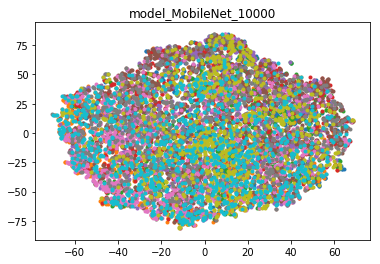

In [16]:
%%time
tsne_plot(model=model1)